In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import gc
from sklearn.model_selection import train_test_split
import tensorflow
import gensim
import numpy as np
%matplotlib inline

/home/weimin/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
pd.set_option('display.max_columns',60)

In [3]:
path = ""
aisles = pd.read_csv(path+"aisles.csv")
products = pd.read_csv(path+"products.csv")
departments = pd.read_csv(path+"departments.csv")
orders = pd.read_csv(path+"orders.csv")
dtrain = pd.read_csv(path+"order_products__train.csv")
dprior = pd.read_csv(path+"order_products__prior.csv", nrows=1000000)
sample_submission = pd.read_csv(path + "sample_submission.csv")

In [4]:
print "ailes = (%10d,%3d)\t"%aisles.shape, aisles.columns
print "\nproducts = (%10d,%3d)\t"%products.shape, products.columns
print "\ndepartments = (%10d,%3d)\t"%departments.shape,departments.columns
print "\norders = ",orders.shape, "\t\t", orders.columns
print "\ndtrain = ",dtrain.shape, "\t\t", dtrain.columns
print "\ndprior",dprior.shape, "\t\t", dprior.columns

ailes = (       134,  2)	Index([u'aisle_id', u'aisle'], dtype='object')

products = (     49688,  4)	Index([u'product_id', u'product_name', u'aisle_id', u'department_id'], dtype='object')

departments = (        21,  2)	Index([u'department_id', u'department'], dtype='object')

orders =  (3421083, 7) 		Index([u'order_id', u'user_id', u'eval_set', u'order_number', u'order_dow',
       u'order_hour_of_day', u'days_since_prior_order'],
      dtype='object')

dtrain =  (1384617, 4) 		Index([u'order_id', u'product_id', u'add_to_cart_order', u'reordered'], dtype='object')

dprior (1000000, 4) 		Index([u'order_id', u'product_id', u'add_to_cart_order', u'reordered'], dtype='object')


In [5]:
prior_details = dprior.merge(orders[orders.eval_set == "prior"],how="left",on="order_id")

In [6]:
prior_details.head(2)

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,202279,prior,3,5,9,8.0
1,2,28985,2,1,202279,prior,3,5,9,8.0


In [7]:
def add_groupby_features(df, group_cols, agg_dict):
#    print "grouping in process..."
    grouped = df.groupby(group_cols).agg(agg_dict)
    grouped.columns = grouped.columns.droplevel(0)
    grouped.reset_index(inplace=True)
#    print "group done."
    return grouped

In [8]:
def ka_add_groupby_features_n_vs_1(df, group_columns_list, target_columns_list, methods_list):
        grouped_name = ''.join(group_columns_list)
        target_name = ''.join(target_columns_list)
        combine_name = [[grouped_name] + [method_name] + [target_name] for method_name in methods_list]

        grouped = df.groupby(group_columns_list)

        the_stats = grouped[target_name].agg(methods_list).reset_index()
        the_stats.columns = [grouped_name] + \
                            ['_%s_%s_by_%s' % (grouped_name, method_name, target_name) \
                             for (grouped_name, method_name, target_name) in combine_name]
        return the_stats

# Create Product Features

In [26]:
#####?????? check "sum" for nan values
#Which times does the user buy the product in an order?
prior_details["_userprod_nth_time"] = prior_details.groupby(["user_id","product_id"]).cumcount() + 1
agg_dict1 = {"user_id":{"_prod_total_purchase_cnts":"sum"},
         "reordered":{"_prod_reordered_total_cnts":"sum"},
        "_userprod_nth_time":{"_prod_first_purchase_total_cnts":lambda x: sum(x==1),
                                  "_prod_second_purchase_total_cnts":lambda x: sum(x==2),
                                  "_prod_multiple_purchase_total_cnts":lambda x: sum(x>1)}}
product_features = add_groupby_features(prior_details,["product_id"],agg_dict1)

In [27]:
prior_details.head(2)

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,_userprod_nth_time
0,2,33120,1,1,202279,prior,3,5,9,8.0,1
1,2,28985,2,1,202279,prior,3,5,9,8.0,1
2,2,9327,3,0,202279,prior,3,5,9,8.0,1
3,2,45918,4,1,202279,prior,3,5,9,8.0,1
4,2,30035,5,0,202279,prior,3,5,9,8.0,1


In [28]:
agg_dict12 = {'order_dow':{'_prod_average_dow':'mean', '_prod_frequent_dow':lambda x: x.value_counts().idxmax()}, 
            'order_hour_of_day':{'_prod_average_hour':'mean', '_prod_frequent_hour':lambda x: x.value_counts().idxmax()}} 

prod_temp = add_groupby_features(prior_details, ['product_id'], agg_dict12)
product_features = product_features.merge(prod_temp,on="product_id",how="left")

In [29]:
agg_dict15 = {'user_id':{'_prod_distinct_users':lambda x:x.nunique()},
             'add_to_cart_order':{'_prod_mean_cart_position':'mean'}} 

prod_temp = add_groupby_features(prior_details, ['product_id'], agg_dict15)
product_features = product_features.merge(prod_temp,on="product_id",how="left")

In [30]:
#add word vectors using product_id
model = gensim.models.Word2Vec.load("product2vec.model")
vocab = list(model.wv.vocab.keys())
word_vectors = model.wv.syn0
wv_sum = np.sum(word_vectors, axis=1)
df_wv = pd.DataFrame({"product_id":[int(x) for x in vocab], "_prod_wv":wv_sum})
df_wv.head(1)

,_prod_wv,product_id
0,41.695309,44884


In [31]:
product_features = product_features.merge(df_wv,on="product_id",how="left")

In [32]:
prod_misc = products.merge(aisles,how="left",on="aisle_id").merge(departments, how="left",on="department_id")

In [33]:
prod_misc.head(2)

,product_id,product_name,aisle_id,department_id,aisle,department
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
1,2,All-Seasons Salt,104,13,spices seasonings,pantry


In [34]:
prod_misc["_is_organic"] = [int("Organic" in x) for x in prod_misc.product_name]
prod_misc["_is_banana"] = [int("banana" in x or "Banana" in x) for x in products.product_name]
prod_misc["_is_sweet"] = [int("sweet" in x or "Sweet" in x) for x in products.product_name]
prod_misc["_is_fruit"] = [int("fruit" in x or "Fruit" in x) for x in products.product_name]
prod_misc["_is_fresh"] = [int("fresh" in x or "Fresh" in x) for x in products.product_name]

In [35]:
prod_misc.head(2)

,product_id,product_name,aisle_id,department_id,aisle,department,_is_organic,_is_banana,_is_sweet,_is_fruit,_is_fresh
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks,0,0,0,0,0
1,2,All-Seasons Salt,104,13,spices seasonings,pantry,0,0,0,0,0


In [36]:
product_features = product_features.merge(prod_misc,on="product_id",how="left")

In [37]:
product_features.head(2)

,product_id,_prod_multiple_purchase_total_cnts,_prod_first_purchase_total_cnts,_prod_second_purchase_total_cnts,_prod_total_purchase_cnts,_prod_reordered_total_cnts,_prod_frequent_hour,_prod_average_hour,_prod_frequent_dow,_prod_average_dow,_prod_mean_cart_position,_prod_distinct_users,_prod_wv,product_name,aisle_id,department_id,aisle,department,_is_organic,_is_banana,_is_sweet,_is_fruit,_is_fresh
0,1,3,56,3,6199740,41,14,13.762712,1,2.644068,5.457627,56,-0.952363,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks,0,0,0,0,0
1,2,0,3,0,96585,0,16,13.000000,0,1.333333,12.000000,3,1.125929,All-Seasons Salt,104,13,spices seasonings,pantry,0,0,0,0,0


In [38]:
product_features['_prod_reorder_prob'] = product_features._prod_second_purchase_total_cnts / product_features._prod_first_purchase_total_cnts
product_features['_prod_reorder_ratio'] = product_features._prod_reordered_total_cnts / product_features._prod_total_purchase_cnts
product_features['_prod_reorder_times'] = 1 + product_features._prod_reordered_total_cnts / product_features._prod_reordered_total_cnts
#_prod_reorder_ratio = 1/_prod_reorder_times

In [39]:
product_features.to_csv("product_features.csv",index=False)

# Create User Features

In [40]:
agg_dict2 = {"order_number":{"_user_total_orders":"max"},
            "days_since_prior_order":{"_user_membership_days":"sum","_user_mean_order_period":"mean"}}

user_features = add_groupby_features(orders[orders.eval_set=="prior"],["user_id"],agg_dict2)

In [41]:
user_features.head(1)

,user_id,_user_membership_days,_user_mean_order_period,_user_total_orders
0,1,176.0,19.555556,10


In [42]:
agg_dict3 = {"reordered":{"_user_reorder_ratio":lambda x:sum(x)/float(len(x))}}
user_temp = add_groupby_features(prior_details[prior_details.order_number>1],["user_id"],agg_dict3)
user_features = user_features.merge(user_temp,on="user_id",how="left")
del user_temp
gc.collect()

561

In [43]:
agg_dict4 = {"product_id":{"_user_total_products":'count',
                          "_user_distinct_products": lambda x: x.nunique()}}
user_temp = add_groupby_features(prior_details,["user_id"],agg_dict4)
user_features = user_features.merge(right=user_temp,on="user_id",how="left")

In [44]:
agg_dict5 = {'product_id':{'each_order_cnts':'count'}}
user_temp = add_groupby_features(prior_details,["order_id"],agg_dict5)
user_temp = user_temp.merge(right=orders[orders.eval_set=="prior"][["order_id","user_id"]],how="left",on="order_id")


agg_dict6 = {'each_order_cnts':{'_user_mean_basket':'mean',
                                 '_user_median_basket':'median',
                                 '_user_min_basket':'min', 
                                 "_user_max_basket":'max', }}
user_temp = add_groupby_features(user_temp,["user_id"],agg_dict6)
user_features = user_features.merge(right=user_temp,on="user_id",how="left")

In [45]:
user_temp = orders[orders.eval_set != "prior"]
user_features = user_features.merge(right=user_temp,on="user_id",how="left")

In [46]:
agg_dict13 = {'order_dow':{'_user_average_dow':'mean', '_user_frequent_dow':lambda x: x.value_counts().idxmax()}, 
            'order_hour_of_day':{'_user_average_hour':'mean', '_user_frequent_hour':lambda x: x.value_counts().idxmax()}} 

user_temp= add_groupby_features(prior_details, ['user_id'], agg_dict13)
user_features = user_features.merge(right=user_temp,on="user_id",how="left")

In [47]:
user_features.head(2)

,user_id,_user_membership_days,_user_mean_order_period,_user_total_orders,_user_reorder_ratio,_user_total_products,_user_distinct_products,_user_min_basket,_user_mean_basket,_user_max_basket,_user_median_basket,order_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,_user_average_hour,_user_frequent_hour,_user_frequent_dow,_user_average_dow
0,1,176.0,19.555556,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1187899,train,11,4,8,14.0,NaN,NaN,NaN,NaN
1,2,198.0,15.230769,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1492625,train,15,1,11,30.0,NaN,NaN,NaN,NaN


# Add User_Products Features

In [48]:
agg_dict7 = {'order_number':{'_userprod_order_total_cnts': 'count', 
                              '_userprod_first_order_number': 'min', 
                              '_userprod_last_order_number':'max'}, 
              'add_to_cart_order':{'_userprod_average_cart_position': 'mean'}}

userprod_features = add_groupby_features(prior_details, ['user_id', 'product_id'], agg_dict7)

In [49]:
userprod_features.head(2)

,user_id,product_id,_userprod_average_cart_position,_userprod_last_order_number,_userprod_order_total_cnts,_userprod_first_order_number
0,4,22199,1.0,4,1,4
1,4,25146,2.0,4,1,4


# Combine Features and Create More Features

In [50]:
data = userprod_features.merge(product_features, how='inner', on='product_id').merge(user_features, how='inner', on='user_id')

In [51]:
data['_userprod_order_rate'] = data._userprod_order_total_cnts / data._user_total_orders
data['_userprod_order_cnt_since_last_order'] = data._user_total_orders - data._userprod_last_order_number
data['_userprod_order_rate_since_first_order'] = data._userprod_order_total_cnts / (data._user_total_orders - data._userprod_first_order_number + 1)

data["_user_match_dow"] = abs(np.array(data._user_frequent_dow) - np.array(data.order_dow))
data["_user_match_hour"] = abs(np.array(data._user_frequent_hour) - np.array(data.order_hour_of_day))
data["_prod_match_hour"] = abs(np.array(data._prod_frequent_hour) - np.array(data.order_hour_of_day))
data["_prod_match_dow"] = abs(np.array(data._prod_frequent_dow) - np.array(data.order_dow))

In [52]:
print data.shape
data.head(2)

(913919, 58)


,user_id,product_id,_userprod_average_cart_position,_userprod_last_order_number,_userprod_order_total_cnts,_userprod_first_order_number,_prod_multiple_purchase_total_cnts,_prod_first_purchase_total_cnts,_prod_second_purchase_total_cnts,_prod_total_purchase_cnts,_prod_reordered_total_cnts,_prod_frequent_hour,_prod_average_hour,_prod_frequent_dow,_prod_average_dow,_prod_mean_cart_position,_prod_distinct_users,_prod_wv,product_name,aisle_id,department_id,aisle,department,_is_organic,_is_banana,_is_sweet,_is_fruit,_is_fresh,_prod_reorder_prob,_prod_reorder_ratio,_prod_reorder_times,_user_membership_days,_user_mean_order_period,_user_total_orders,_user_reorder_ratio,_user_total_products,_user_distinct_products,_user_min_basket,_user_mean_basket,_user_max_basket,_user_median_basket,order_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,_user_average_hour,_user_frequent_hour,_user_frequent_dow,_user_average_dow,_userprod_order_rate,_userprod_order_cnt_since_last_order,_userprod_order_rate_since_first_order,_user_match_dow,_user_match_hour,_prod_match_hour,_prod_match_dow
0,4,22199,1.0,4,1,4,0,2,0,47333,0,10,11.500000,3,4.000000,1.000000,2,-11.637556,Extra-Dry Cava,134,5,specialty wines champagnes,alcohol,0,0,0,0,0,0.000000,0.000000,NaN,55.0,13.75,5,0.0,2.0,2.0,2.0,2.0,2.0,2.0,329954,test,6,3,12,30.0,13.0,13.0,5.0,5.0,0.2,1,0.5,2.0,1.0,2,0
1,4,25146,2.0,4,1,4,77,683,67,82160751,493,12,13.632895,1,2.848684,7.044737,683,15.051647,Original Orange Juice,31,7,refrigerated,beverages,0,0,0,0,0,0.098097,0.000006,2.0,55.0,13.75,5,0.0,2.0,2.0,2.0,2.0,2.0,2.0,329954,test,6,3,12,30.0,13.0,13.0,5.0,5.0,0.2,1,0.5,2.0,1.0,0,2


In [54]:
# add user_id to train set
dtrain = dtrain.merge(right=orders[['order_id', 'user_id']], how='left', on='order_id')
data = data.merge(dtrain[['user_id', 'product_id', 'reordered']], on=['user_id', 'product_id'], how='left')


# XGB

In [55]:
train = data[data.eval_set == "train"]
train['reordered'] = train.reordered.fillna(0)

/home/weimin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [56]:
train.head()

,user_id,product_id,_userprod_average_cart_position,_userprod_last_order_number,_userprod_order_total_cnts,_userprod_first_order_number,_prod_multiple_purchase_total_cnts,_prod_first_purchase_total_cnts,_prod_second_purchase_total_cnts,_prod_total_purchase_cnts,_prod_reordered_total_cnts,_prod_frequent_hour,_prod_average_hour,_prod_frequent_dow,_prod_average_dow,_prod_mean_cart_position,_prod_distinct_users,_prod_wv,product_name,aisle_id,department_id,aisle,department,_is_organic,_is_banana,_is_sweet,_is_fruit,_is_fresh,_prod_reorder_prob,_prod_reorder_ratio,_prod_reorder_times,_user_membership_days,_user_mean_order_period,_user_total_orders,_user_reorder_ratio,_user_total_products,_user_distinct_products,_user_min_basket,_user_mean_basket,_user_max_basket,_user_median_basket,order_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,_user_average_hour,_user_frequent_hour,_user_frequent_dow,_user_average_dow,_userprod_order_rate,_userprod_order_cnt_since_last_order,_userprod_order_rate_since_first_order,_user_match_dow,_user_match_hour,_prod_match_hour,_prod_match_dow,reordered
45,982,25146,32.0,3,1,3,77,683,67,82160751,493,12,13.632895,1,2.848684,7.044737,683,15.051647,Original Orange Juice,31,7,refrigerated,beverages,0,0,0,0,0,0.098097,0.000006,2.0,302.0,25.166667,13,0.507246,69.0,62.0,33.0,34.5,36.0,34.5,1759116,train,14,0,10,11.0,15.826087,12.0,0.0,0.0,0.076923,10,0.090909,0.0,2.0,2,1,0.0
46,982,11520,10.5,6,2,3,156,1068,126,126075919,934,16,13.362745,0,2.721405,5.938725,1068,-0.846872,Large Alfresco Eggs,86,16,eggs,dairy eggs,0,0,0,0,0,0.117978,0.000007,2.0,302.0,25.166667,13,0.507246,69.0,62.0,33.0,34.5,36.0,34.5,1759116,train,14,0,10,11.0,15.826087,12.0,0.0,0.0,0.153846,7,0.181818,0.0,2.0,6,0,0.0
47,982,27344,20.0,6,1,6,115,1179,102,132697243,849,16,13.323029,0,2.675425,8.792117,1179,-2.570976,Uncured Genoa Salami,96,20,lunch meat,deli,0,0,0,0,0,0.086514,0.000006,2.0,302.0,25.166667,13,0.507246,69.0,62.0,33.0,34.5,36.0,34.5,1759116,train,14,0,10,11.0,15.826087,12.0,0.0,0.0,0.076923,7,0.125000,0.0,2.0,6,0,0.0
48,982,11782,31.0,6,1,6,18,447,18,46536395,260,11,13.651613,0,2.774194,9.023656,447,0.173631,Bing Cherries,24,4,fresh fruits,produce,0,0,0,0,0,0.040268,0.000006,2.0,302.0,25.166667,13,0.507246,69.0,62.0,33.0,34.5,36.0,34.5,1759116,train,14,0,10,11.0,15.826087,12.0,0.0,0.0,0.076923,7,0.125000,0.0,2.0,1,0,0.0
49,982,28535,22.0,3,1,3,20,207,19,22559548,139,13,13.621145,0,2.515419,10.114537,207,-0.243388,Cucumber & Garlic Tzatziki,51,13,preserved dips spreads,pantry,0,0,0,0,0,0.091787,0.000006,2.0,302.0,25.166667,13,0.507246,69.0,62.0,33.0,34.5,36.0,34.5,1759116,train,14,0,10,11.0,15.826087,12.0,0.0,0.0,0.076923,10,0.090909,0.0,2.0,3,0,0.0


In [57]:
sum(train.reordered)

110035.0

In [58]:
# subsample 让training时间更短
X_train, X_val, y_train, y_val = train_test_split(train.drop(['reordered',"eval_set","user_id","product_id","order_id","aisle_id","department_id","product_name","aisle","department"], axis=1), train.reordered,
                                                    test_size=0.3, random_state=42) #['eval_set','reordered', 'product_id','user_id', 'order_id']
print "splitting done"
#del train
gc.collect()

d_train = xgb.DMatrix(X_train, y_train)
d_val = xgb.DMatrix(X_val,y_val)
print "DMatrix done"

splitting done
DMatrix done


In [59]:
%%time

xgb_params = {
    "objective"         : "reg:logistic"
    ,"eval_metric"      : "logloss"
    ,"eta"              : 0.1
    ,"max_depth"        : 6
    ,"min_child_weight" :10
    ,"gamma"            :0.70
    ,"subsample"        :0.76
    ,"colsample_bytree" :0.95
    ,"alpha"            :2e-05
    ,"lambda"           :10
}

watchlist= [(d_train, "train"),(d_val,'val')]
bst = xgb.train(params=xgb_params, dtrain=d_train, num_boost_round=50, early_stopping_rounds=10, evals=watchlist, verbose_eval=10)

bst.save_model("bst19.model")

[0]	train-logloss:0.651652	val-logloss:0.651768
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 10 rounds.
[10]	train-logloss:0.477861	val-logloss:0.478944
[20]	train-logloss:0.441287	val-logloss:0.443252
[30]	train-logloss:0.430989	val-logloss:0.433874
[40]	train-logloss:0.426336	val-logloss:0.430128
CPU times: user 2min 35s, sys: 9.08 s, total: 2min 44s
Wall time: 42.9 s


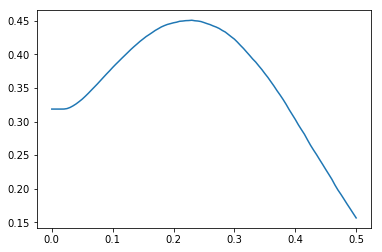

p value for max F1 score: 0.23
Maximum F1 score: 0.450569954374


In [89]:
#Find the threshhold p to get best F1-score

from sklearn.metrics import f1_score
p_list = np.linspace(0,0.5,num=101)
score_list = []
for p in p_list:
    score = f1_score(y_true=y_train, y_pred=(bst.predict(d_train) > p).astype(int))
    score_list = score_list+[score]
plt.plot(p_list,score_list)
plt.show()
print "p value for max F1 score:", p_list[np.argmax(score_list)]
print "Maximum F1 score:", max(score_list)
best_p = p_list[np.argmax(score_list)]

In [75]:
[1,2]+[3,4]

[1, 2, 3, 4]

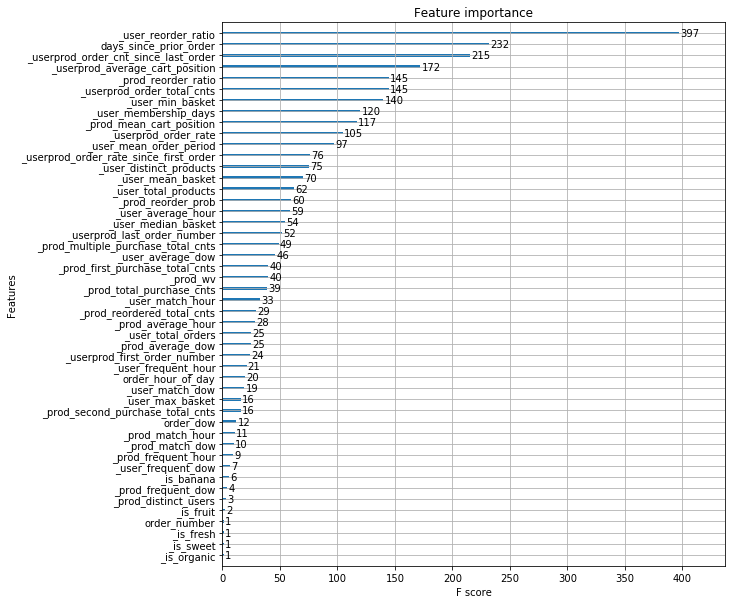

In [60]:
bst.save_model("model_3.model")
bst.dump_model('model_3.txt')
#xgb.plot_importance(bst)
ax = xgb.plot_importance(bst)
fig = ax.figure
fig.set_size_inches(9, 10)

In [61]:
X_test = data.loc[data.eval_set == "test",:]
d_test = xgb.DMatrix(X_test.drop(['reordered',"eval_set","user_id","product_id","order_id","aisle_id","department_id","product_name","aisle","department"], axis=1))


In [62]:
X_test.loc[:,'reordered'] = (bst.predict(d_test) > best_p).astype(int)
X_test.loc[:, 'product_id'] = X_test.product_id.astype(str)#to make str joining convenient

/home/weimin/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [63]:
X_test.head(2)

,user_id,product_id,_userprod_average_cart_position,_userprod_last_order_number,_userprod_order_total_cnts,_userprod_first_order_number,_prod_multiple_purchase_total_cnts,_prod_first_purchase_total_cnts,_prod_second_purchase_total_cnts,_prod_total_purchase_cnts,_prod_reordered_total_cnts,_prod_frequent_hour,_prod_average_hour,_prod_frequent_dow,_prod_average_dow,_prod_mean_cart_position,_prod_distinct_users,_prod_wv,product_name,aisle_id,department_id,aisle,department,_is_organic,_is_banana,_is_sweet,_is_fruit,_is_fresh,_prod_reorder_prob,_prod_reorder_ratio,_prod_reorder_times,_user_membership_days,_user_mean_order_period,_user_total_orders,_user_reorder_ratio,_user_total_products,_user_distinct_products,_user_min_basket,_user_mean_basket,_user_max_basket,_user_median_basket,order_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,_user_average_hour,_user_frequent_hour,_user_frequent_dow,_user_average_dow,_userprod_order_rate,_userprod_order_cnt_since_last_order,_userprod_order_rate_since_first_order,_user_match_dow,_user_match_hour,_prod_match_hour,_prod_match_dow,reordered
0,4,22199,1.0,4,1,4,0,2,0,47333,0,10,11.500000,3,4.000000,1.000000,2,-11.637556,Extra-Dry Cava,134,5,specialty wines champagnes,alcohol,0,0,0,0,0,0.000000,0.000000,NaN,55.0,13.75,5,0.0,2.0,2.0,2.0,2.0,2.0,2.0,329954,test,6,3,12,30.0,13.0,13.0,5.0,5.0,0.2,1,0.5,2.0,1.0,2,0,0
1,4,25146,2.0,4,1,4,77,683,67,82160751,493,12,13.632895,1,2.848684,7.044737,683,15.051647,Original Orange Juice,31,7,refrigerated,beverages,0,0,0,0,0,0.098097,0.000006,2.0,55.0,13.75,5,0.0,2.0,2.0,2.0,2.0,2.0,2.0,329954,test,6,3,12,30.0,13.0,13.0,5.0,5.0,0.2,1,0.5,2.0,1.0,0,2,0


In [64]:
submit = ka_add_groupby_features_n_vs_1(X_test[X_test.reordered == 1], 
                                               group_columns_list=['order_id'],
                                               target_columns_list= ['product_id'],
                                               methods_list=[lambda x: ' '.join(list(x))])
submit.head(2)

,order_id,_order_id_<function <lambda> at 0x7faa1946dde8>_by_product_id
0,34,46979 9839 44663
1,452,19019 36735 21137 13176 24964 47209 4605 27966...


In [65]:
#change column names
submit.columns = sample_submission.columns.tolist()
submit_final = sample_submission[['order_id']].merge(submit, how='left').fillna('None')
submit_final.head()

,order_id,products
0,17,None
1,34,46979 9839 44663
2,137,None
3,182,None
4,257,None


In [66]:
print sum(submit_final.products=="None"),len(submit_final.products)

54266 75000


In [67]:
submit_final.to_csv("20170812_trial 1_trees_%data.csv", index=False)